<center><img src="../images/logo.png"/></center>

SynthGauge is a Python library providing a framework in which to evaluate synthetically generated data.

This notebook provides a basic example workflow for using SynthGauge. For further details on the functionality of the package, see the docs (LINK??).

In [1]:
import synthgauge as sg

%matplotlib inline

Throughout we will be using toy datasets created using the `make_classification()` function in `sklearn`.

In [2]:
real_data = sg.datasets.make_blood_types_df(noise = 0, random_seed = 101)
synth_data = sg.datasets.make_blood_types_df(noise = 1, random_seed = 101)

print(real_data.head())
print('\n')
print(synth_data.head())

    age  height  weight hair_colour eye_colour blood_type
0  39.0   180.0    76.0       Black      Green          A
1  48.0   178.0    82.0       Black      Brown          B
2  35.0   168.0    68.0       Black      Brown          B
3  39.0   172.0    82.0       Brown       Blue          O
4  61.0   161.0    84.0       Brown       Blue          B


    age  height  weight hair_colour eye_colour blood_type
0  55.0   184.0    81.0       Black      Brown          A
1  43.0   181.0    70.0       Brown      Brown          B
2  36.0   163.0    62.0       Brown      Brown         AB
3  54.0   176.0    84.0      Blonde       Blue          O
4  60.0   163.0    85.0       Brown      Brown          B


SynthGauge revolves around a central `Evaluator` object that must first be instantiated.

In [3]:
E = sg.Evaluator(real_data, synth_data)

We can then use in-built methods to see summary statistics of the data.

In [4]:
E.describe_categorical()

,count,unique,most_frequent,freq
blood_type_real,1000,4,O,374
blood_type_synth,1000,4,A,365
eye_colour_real,1000,3,Brown,643
eye_colour_synth,1000,3,Brown,697
hair_colour_real,1000,4,Brown,468
hair_colour_synth,1000,4,Brown,529


In [5]:
E.describe_numeric()

,count,mean,std,min,25%,50%,75%,max
age_real,1000.0,41.792,8.465483,16.0,36.0,41.0,47.0,77.0
age_synth,1000.0,42.163,10.097940,8.0,35.0,42.0,49.0,76.0
height_real,1000.0,173.879,8.704029,149.0,168.0,174.0,180.0,204.0
height_synth,1000.0,174.069,10.780931,138.0,166.0,174.0,182.0,207.0
weight_real,1000.0,78.265,9.952579,47.0,72.0,79.0,85.0,113.0
weight_synth,1000.0,78.137,11.726199,43.0,71.0,78.0,86.0,114.0


# Plotting

The evaluator object has methods to visually compare the real and synthetic data.

`plot_histograms()` allows us to look at the univariate distribution of the features.

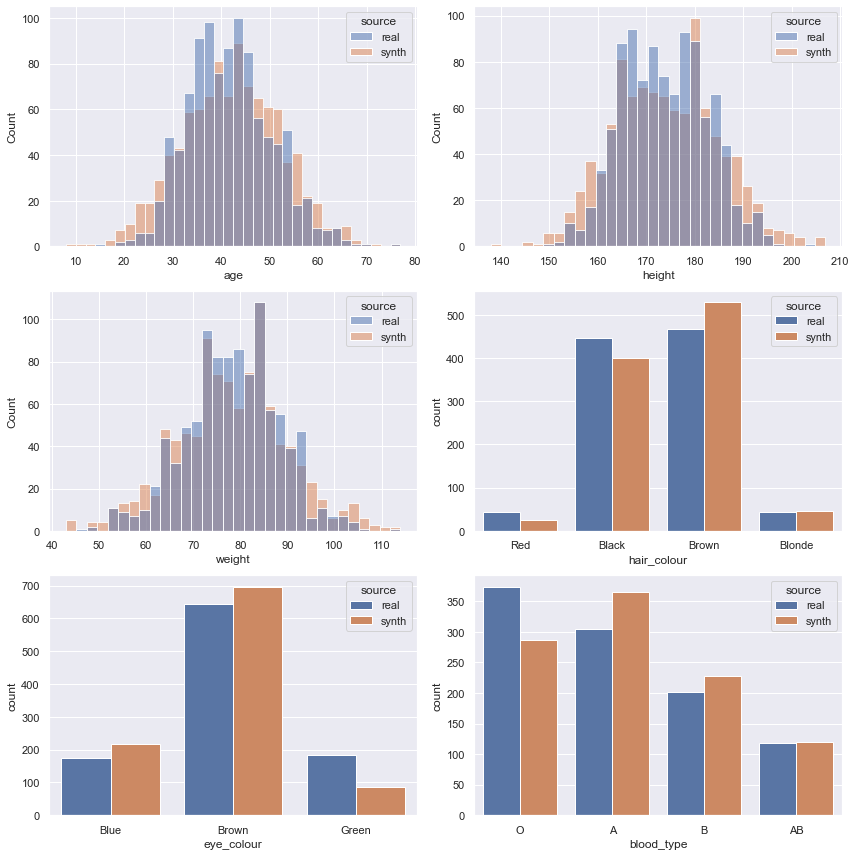

In [6]:
E.plot_histograms(figsize=(12,12));

`plot_correlation()` lets us look at the relationships between variables. The third plot shows the difference between the correlation scores.

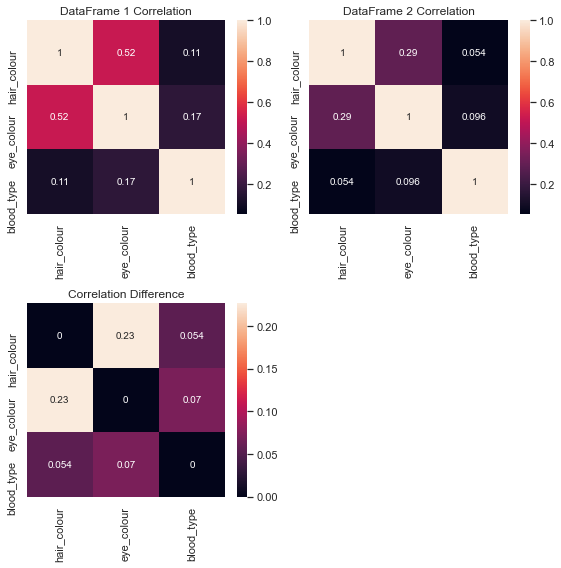

In [7]:
E.plot_correlation(feats=['hair_colour','eye_colour','blood_type'], method='cramers_v', figsize=(8,8), annot=True);

Here we see that the features `hair_colour` and `eye_colour` seem to have the biggest difference between their correlation in the real dataset and in the synthetic dataset. We could use the `plot_crosstab()` method to investigate this further.

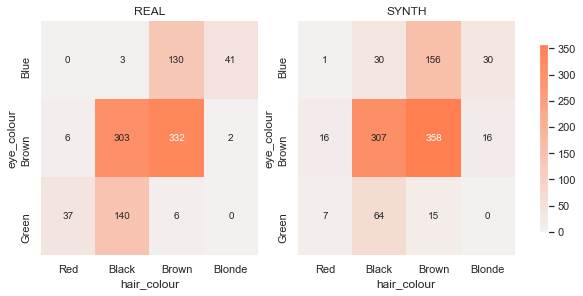

In [8]:
E.plot_crosstab('hair_colour','eye_colour', figsize=(8, 4), cmap="light:coral", annot=True, fmt='d');

# Metrics

We can also evaluate the synthetic data using metrics. These first need to be added to the evaluator before running the `evaluate()` method. To add these metrics we use the `add_metric()` method, specifying the metric name, optionally an alias, followed by keyword arguments that will be passed to the metric function.

In [9]:
#univariate distribution comparisons
E.add_metric('wasserstein','wass-age', feature = 'age')
E.add_metric('wasserstein','wass-height', feature = 'height')
E.add_metric('wasserstein','wass-weight', feature = 'weight')
E.add_metric('jensen_shannon_distance','jenshan-hair',feature='hair_colour', bins = None)
E.add_metric('jensen_shannon_distance','jenshan-eye',feature='eye_colour', bins = None)
E.add_metric('jensen_shannon_distance','jenshan-blood',feature='blood_type', bins = None)

#correlations
E.add_metric('cramers_v_MSE')

#general utility
E.add_metric('propensity_metrics')

E.evaluate(as_df=True)

,value
wass-age,1.579000
wass-height,1.634000
wass-weight,1.414000
jenshan-hair,0.054061
jenshan-eye,0.103312
jenshan-blood,0.067900
cramers_v_MSE,0.019818
propensity_metrics-observed_p_MSE,0.249500
propensity_metrics-standardised_p_MSE,7.635270
propensity_metrics-ratio_p_MSE,1.018541


More details about the specific metrics can be found in the documentation or by using the help function.

In [10]:
help(sg.metrics.univariate_distance.wasserstein)

Help on function wasserstein in module synthgauge.metrics.univariate_distance:

wasserstein(real, synth, feature, **kwargs)
    Distance: Wasserstein
    
    The Wasserstein distance, or Earth Mover's distance, can be thought of as
    calculating the amount of "work" required to move from the distribution of
    the synthetic data to the distribution of the real data.
    
    Parameters
    ----------
    real : pandas dataframe
        Dataframe containing the real data.
    synth : pandas dataframe
        Dataframe containing the synthetic data.
    feature : str
        String indicating the feature of the datasets to compare. This must be
        a continuous variable.
    **kwargs : dict
        Keyword arguments.
    
    Returns
    -------
    distance : float
        The computed distance between the distributions.
    
    See Also
    --------
    scipy.stats.wasserstein_distance
    
    Notes
    -----
    This is a wrapper function for `scipy.stats.wasserstein_distanc

It is possible to also add user-defined metrics to the Evaluator object to accommodate specific use cases. The custom_metric() method takes as inputs a name to be displayed in the results table and a function which will be given the real and synthetic datasets as the first and second arguments respectively. Keyword arguments can be specified to pass other parameters to the metric function.

In [11]:
from scipy.stats import skew

# Toy custom metric
def skew_difference(real, synth, feat):
    real_skew = skew(real[feat])
    synth_skew = skew(synth[feat]) 
    return abs(real_skew - synth_skew)

# Add the metric to the Evaluator's metrics catalog under the alias 'skew_diff'
E.add_custom_metric('skew-diff-age', skew_difference, feat='age')

# The custom metric will now be evaluated along with any previously specified
E.evaluate(as_df=True)

,value
wass-age,1.579000
wass-height,1.634000
wass-weight,1.414000
jenshan-hair,0.054061
jenshan-eye,0.103312
jenshan-blood,0.067900
cramers_v_MSE,0.019818
propensity_metrics-observed_p_MSE,0.249500
propensity_metrics-standardised_p_MSE,5.177538
propensity_metrics-ratio_p_MSE,1.018454


# Comparing with another dataset

The functionality of SynthGauge makes it easy to compare different synthetic datasets. It's as simple as creating another evaluator object with the new synthetic datset, running the same plotting methods, and 'copying' the metrics from the first evaluator.

In [12]:
synth_data_comparison = sg.datasets.make_blood_types_df(noise=0.5, random_seed=101)

E_comparison = sg.Evaluator(real_data, synth_data_comparison)

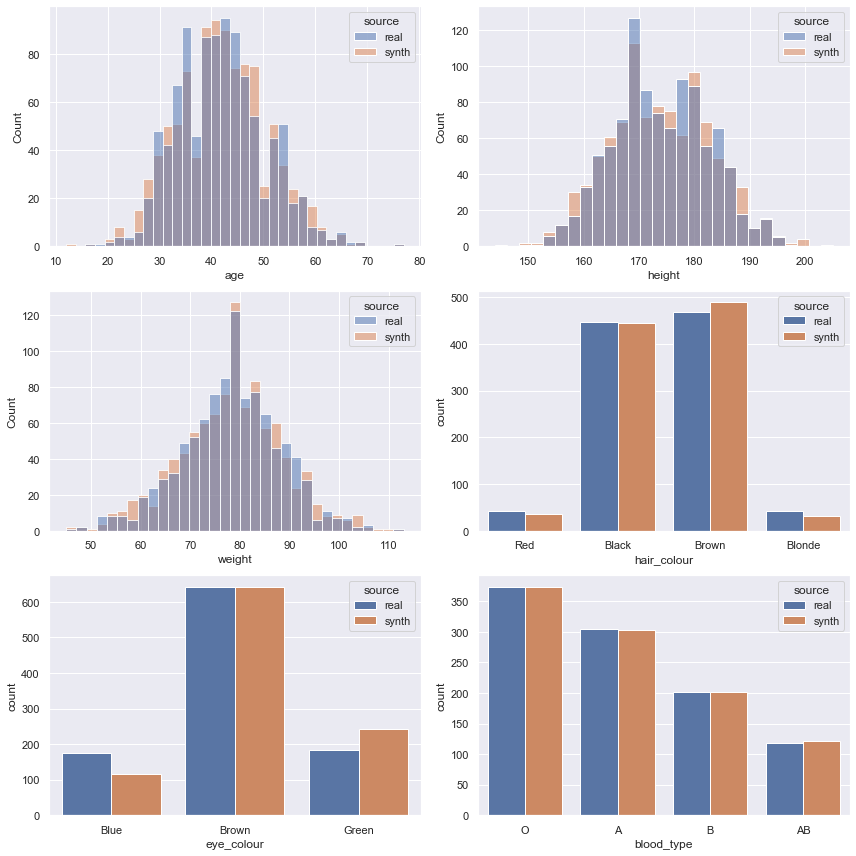

In [13]:
E_comparison.plot_histograms(figsize=(12,12));

In [14]:
E_comparison.copy_metrics(E)
E_comparison.evaluate(as_df=True)

,value
wass-age,0.552000
wass-height,0.552000
wass-weight,0.441000
jenshan-hair,0.026956
jenshan-eye,0.071322
jenshan-blood,0.002411
cramers_v_MSE,0.002887
propensity_metrics-observed_p_MSE,0.246167
propensity_metrics-standardised_p_MSE,3.392229
propensity_metrics-ratio_p_MSE,1.012667
